In [21]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from fancyimpute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Load the data
data = pd.read_csv('payment-practices.csv')

In [23]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

In [24]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [25]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,14673,18.888789
Average time to pay,6859,8.829701
% Invoices paid within 30 days,6859,8.829701
% Invoices paid between 31 and 60 days,6859,8.829701
% Invoices paid later than 60 days,6859,8.829701
% Invoices not paid within agreed terms,6708,8.635316
Shortest (or only) standard payment period,6708,8.635316
Longest standard payment period,30562,39.342954
Maximum contractual payment period,6708,8.635316
Payment terms have changed,6708,8.635316


In [26]:
data = data.dropna(subset=['E-Invoicing offered'])

In [27]:
data['Payments made in the reporting period'].fillna(0, inplace=True)
data['Suppliers notified of changes'].fillna(1, inplace=True)

In [28]:
for col in numerical_features:
    data[col] = data[col].fillna(data[col].mean())

In [29]:
mice_imputer = IterativeImputer()
data_imputed = mice_imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
data = data_imputed

In [30]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


80th Quantile =  47.0


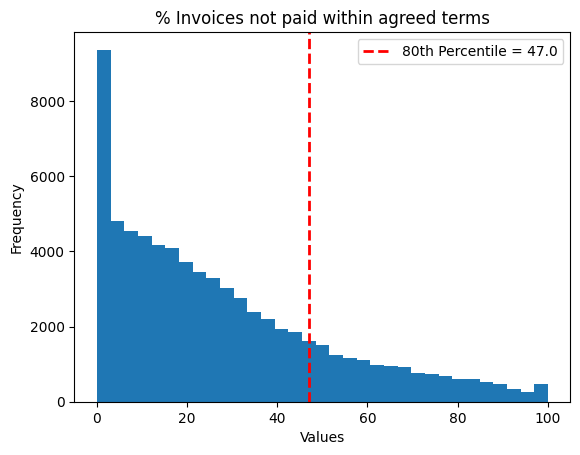

In [31]:
# Bar plot for '% Invoices not paid within agreed terms' and 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [32]:
# Creating target column 'flag' based on the 80th percentile
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

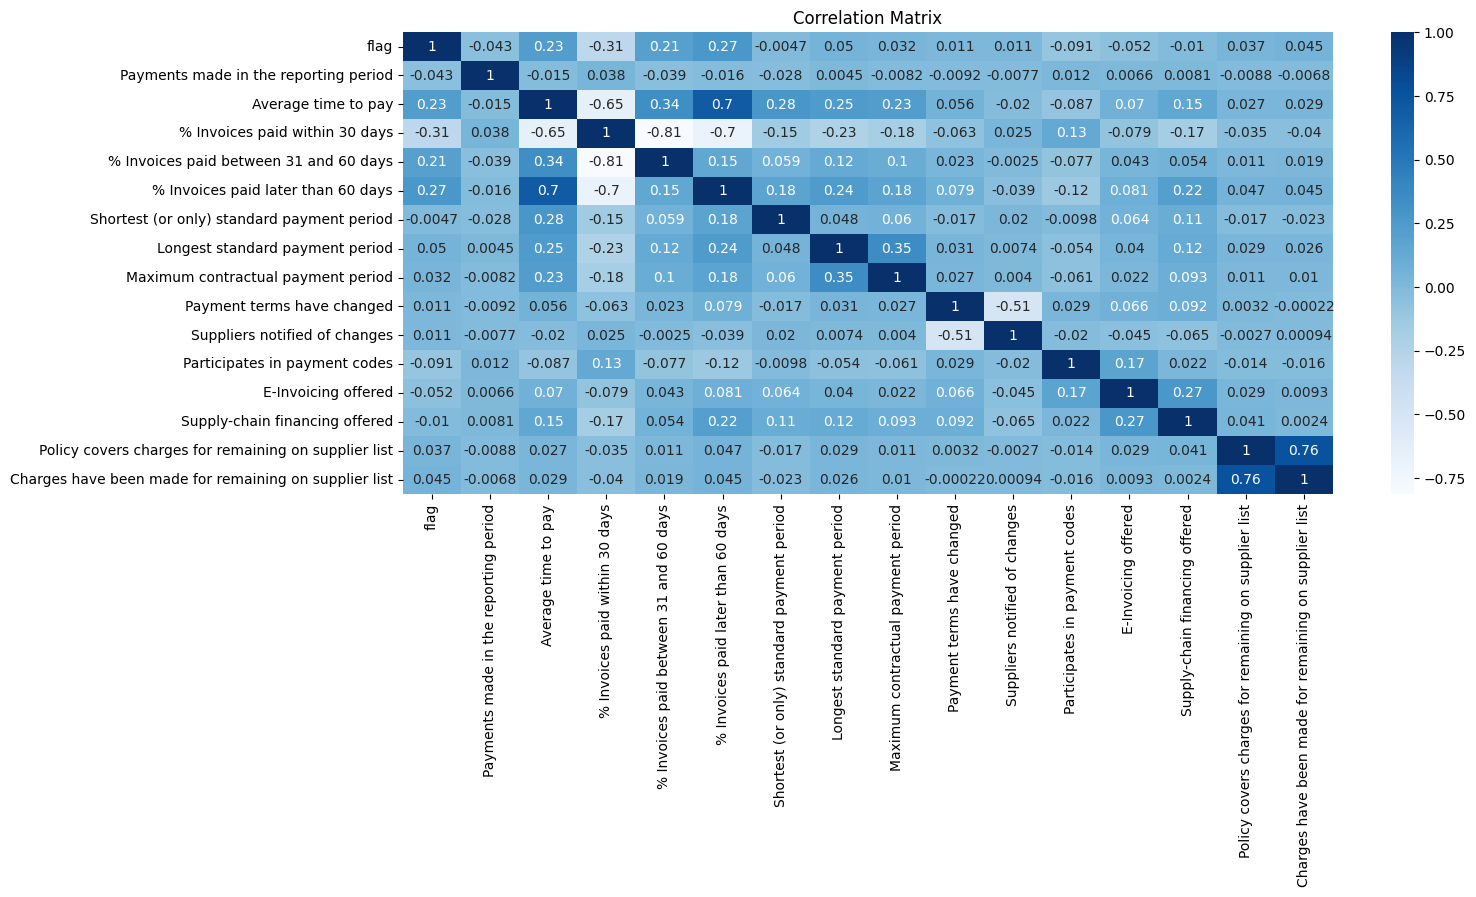

In [33]:
# Correlation Analysis
new_order=[     'flag',
                'Payments made in the reporting period', 'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payment terms have changed', 'Suppliers notified of changes',
                'Participates in payment codes', 'E-Invoicing offered',
                'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
# Visualize the relationship between numerical columns using a correlation matrix
correlation_matrix = data.reindex(columns=new_order).corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix,annot=True,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()



In [34]:
correlation_threshold = 0.7
for feature, feature_values in correlation_matrix.items():
  for other_feature, correlation in feature_values.items():
    if feature != other_feature and abs(correlation) >= correlation_threshold:
      print(f"{feature} is highly correlated with {other_feature} (correlation: {correlation:.2f})")


% Invoices paid within 30 days is highly correlated with % Invoices paid between 31 and 60 days (correlation: -0.81)
% Invoices paid between 31 and 60 days is highly correlated with % Invoices paid within 30 days (correlation: -0.81)
Policy covers charges for remaining on supplier list is highly correlated with Charges have been made for remaining on supplier list (correlation: 0.76)
Charges have been made for remaining on supplier list is highly correlated with Policy covers charges for remaining on supplier list (correlation: 0.76)


In [35]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Suppliers notified of changes',
                            'Policy covers charges for remaining on supplier list',])

In [36]:
X,y = data1.drop(columns=['flag']), data1['flag']
# Implemeting the RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X, y = oversampler.fit_resample(X, y)

In [37]:
# XGBoost Model
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

In [38]:
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

# Define the number of folds
n_splits = 10

# Create an instance of KFold
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_scores = []
f1_scores = []
roc_auc_scores = []

# Iterate over the folds
for train_index, test_index in kfold.split(X):
    # Split the data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create an instance of XGBoost classifier
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate the scores
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred))


average_accuracy = sum(accuracy_scores) / n_splits
average_f1 = sum(f1_scores) / n_splits
average_roc_auc = sum(roc_auc_scores) / n_splits


In [39]:
print("Average Accuracy:", average_accuracy)
print("Average F1 Score:", average_f1)
print("Average ROC AUC Score:", average_roc_auc)

Average Accuracy: 0.8129338704884527
Average F1 Score: 0.8217140268262384
Average ROC AUC Score: 0.8129096994521376
